<a href="https://colab.research.google.com/github/zhy330/Famous-painting-recognition/blob/main/Famous-painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip3 install bdp
!pip install efficientnet-pytorch
!pip install resnest

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=514e94d5088c40a5e09e78c7c02cd3822a7fc4a85e8ade58121a3749c77bf5e3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 154 kB 8.3 MB/s 


In [3]:
#!wget https://data.yanxishe.com/Art.zip
!unzip drive/MyDrive/app/Art.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: train/3003.jpg          
  inflating: train/3004.jpg          
  inflating: train/3005.jpg          
  inflating: train/3006.jpg          
  inflating: train/3007.jpg          
  inflating: train/3008.jpg          
  inflating: train/3009.jpg          
  inflating: train/301.jpg           
  inflating: train/3010.jpg          
  inflating: train/3011.jpg          
  inflating: train/3012.jpg          
  inflating: train/3013.jpg          
  inflating: train/3014.jpg          
  inflating: train/3015.jpg          
  inflating: train/3016.jpg          
  inflating: train/3017.jpg          
  inflating: train/3018.jpg          
  inflating: train/3019.jpg          
  inflating: train/302.jpg           
  inflating: train/3020.jpg          
  inflating: train/3021.jpg          
  inflating: train/3022.jpg          
  inflating: train/3023.jpg          
  inflating: train/3024.jpg          
  inflating: train/3025.jpg          
  inflating: train/3026

In [4]:
import glob
import pandas as pd
import os
import shutil
import torch
import torch.nn.functional as F 
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms,utils
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
# import IBN_ResNet as ibn
from torch.autograd import Variable
from torch.backends import cudnn
import pandas as pd
from efficientnet_pytorch import EfficientNet
from resnest.torch import resnest50
# from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from torch.nn.parameter import Parameter

In [5]:
def dictmap(data, num=1):
    label = []
    fnames = []
    for line in data:
        name = int(line.split('.')[0].split('/')[num])
        fnames.append(name)
        label.append(file['label'][name])
    
    lab_dict = dict(zip(fnames,label))
    
    return lab_dict,label



def default_loader(path):
    return Image.open(path).convert('RGB')



#数据准备
class mydataset(Dataset):
    def __init__(self,data,lab_dict,loader=default_loader,mode='train'):
        super(mydataset,self).__init__() 
        la = []

        for line in data:
            la.append(lab_dict[int(line.split('.')[0].split('/')[1])])
            
        
        self.data = data
        self.loader = loader
        self.mode = mode
        if self.mode == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize(660),
                transforms.RandomCrop(600),#660 600 93.125
                transforms.RandomHorizontalFlip(),
                # transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(40),
                # transforms.RandomAffine(20),
                # transforms.ColorJitter(0.3,0.6,0.3,0.2),#0.6
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
                transforms.RandomErasing(p=0.6,scale=(0.02,0.33),ratio=(0.3,0.33),value=0,inplace=False)
            ])
        else:
            self.transforms = transforms.Compose([
                transforms.Resize(660),
                transforms.RandomCrop(600),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(40),
                # transforms.RandomAffine(20),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            ])
        
        self.la = la
        
    
    def __getitem__(self,index):
        fn = self.data[index] 
        label = self.la[index]
        img = self.loader(fn)
        if self.transforms is not None:
            img = self.transforms(img)
        return img,torch.from_numpy(np.array(label))
    
    def __len__(self):
        return len(self.data)
    
def mixup_data(x, y, alpha=0.2, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """    
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + 
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self,smoothing=0.1):
        super(LabelSmoothingCrossEntropy,self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1 - smoothing
    
    def forward(self,x,target):
        logprobs = F.log_softmax(x,dim=1)
        nll_loss = -logprobs.gather(dim=-1,index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()



def Train_Testloader(data):
    np.random.shuffle(data)
    lab_dict,label = dictmap(data,num=1)
    train_size = int((len(data)) * 0.8)
    # test_size = len(data_jpg) - train_size
    train_idx = data[:train_size]
    test_idx = data[train_size:]
    train_dataset = mydataset(train_idx,lab_dict,loader=default_loader,mode='train')
    test_dataset = mydataset(test_idx,lab_dict,loader=default_loader,mode='test')
    
    train_loader = DataLoader(train_dataset,batch_size=8,shuffle=True,num_workers=0,pin_memory=True)
    test_loader = DataLoader(test_dataset,batch_size=8,shuffle=False,num_workers=0,pin_memory=True)
    
    return train_loader,test_loader

# In[54]:


def plot(loss,acc,epochs,mode='train'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.suptitle('%s_curve' % mode)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(epochs), loss, label='loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(epochs), acc, label='acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(loc='upper left')
    
    plt.show()

    plt.savefig(os.path.join('result', 'resnet18%s.jpg' % mode), bbox_inches='tight')
    plt.close()



class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.base = EfficientNet.from_pretrained('efficientnet-b3')
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._max_pooling = nn.AdaptiveMaxPool2d(1)
        num_ftrs = self.base._fc.in_features
        self.reduce_layer = nn.Conv2d(num_ftrs*2,512,1)#b3 num_ftrs=1536
        self._dropout = nn.Dropout(0.3)
        self._fc = nn.Linear(512,49)

    
    def forward(self,x):
        x = self.base.extract_features(x)
        x1 = self._avg_pooling(x)
        x2 = self._max_pooling(x)
        x = torch.cat([x1,x2],dim=1)
        x = self.reduce_layer(x)
        x = x.flatten(start_dim=1)
        x = self._dropout(x)
        x = self._fc(x)
        return x


# In[56]:


def train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, test_loader):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    trainx_loss = []
    trainx_acc = []
    testx_loss = []
    testx_acc = []
    
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch,num_epochs - 1))      
        print('-'*20)
        
        start = time.time()
        
        train_data_lenth = 0
        test_data_lenth = 0    
        running_loss = 0.0
        running_corrects = 0
        test_loss = 0.0 
        test_corrects = 0
        
        
        model.train()
        #train    
        for data in train_loader:
            inputs,labels = data
   
            inputs = Variable(inputs).cuda()
            labels = Variable(labels).cuda()
            #zero the parameter gradients
            optimizer.zero_grad()
            
            #mixup
            # inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.2, use_cuda=True)
            
            #forward
            outputs = model(inputs)
            #mixup loss
            # loss_mix = mixup_criterion(targets_a,targets_b,lam)
            # loss = loss_mix(criterion,outputs)
            
            _,preds = torch.max(outputs.data,1)
            #original loss
            loss = criterion(outputs,labels)

            #backward
            loss.backward()
            optimizer.step()
            
            #statistics
            running_loss +=loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            train_data_lenth += inputs.size(0)
        
        scheduler.step()
        
        epoch_loss = running_loss / train_data_lenth
        trainx_loss.append(epoch_loss)
        epoch_acc = running_corrects / train_data_lenth
        trainx_acc.append(epoch_acc)
        run_time = time.time() - start
        print('Train Loss:{:.4f} Acc{:.4f} Time{:.2f}s'.format(epoch_loss,epoch_acc,run_time))

        
        
        #test
        
        model.eval()
        with torch.no_grad():
            for data in test_loader:
                inputs,labels = data
                
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                    
                #forward
                outputs = model(inputs)
                _,preds = torch.max(outputs.data,1)
                loss = criterion(outputs,labels)
                test_loss +=loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data).item()
                test_data_lenth += inputs.size(0) 
            
            
            Test_loss = test_loss / test_data_lenth
            testx_loss.append(Test_loss)
            Test_acc = test_corrects / test_data_lenth
            testx_acc.append(Test_acc)
            
            print('Test Loss:{:.4f} Acc{:.4f}'.format(Test_loss,Test_acc))
    
            
            if Test_acc>best_acc:
                best_acc = Test_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            print('Best Acc:{:.4f}'.format(best_acc))
        
        pthpath = 'drive/MyDrive/pth/model.pth'
        torch.save(best_model_wts,pthpath)
        
        with open(os.path.join('drive/MyDrive/pth/','acc.txt'),'a+') as f:
            f.write('Epoch:{:.0f} Train Loss:{:.4f} Train Acc:{:.4f} Test Loss:{:.4f} Test Acc:{:.4f}\n'.format(epoch,epoch_loss,epoch_acc,Test_loss,Test_acc))
        
        
    print('Trainging complete ,Bets Epoch：{:.0f} Best Acc:{:.4f}'.format(best_epoch,best_acc))
    plot(trainx_loss,trainx_acc,num_epochs,mode='Train')
    plot(testx_loss,testx_acc,num_epochs,mode='Test')


In [6]:
seed = 0
torch.manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
# random.seed(seed)
cudnn.deterministic = True
data_jpg = np.array(glob.glob('train/*.jpg'))
print('data_jpg:',len(data_jpg))
file = pd.read_csv('train.csv')

data_jpg: 7227


In [7]:
num_epochs = 5 #after mixup train with original data

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b3')
num_trs = model._fc.in_features
model._fc = nn.Linear(num_trs,49)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Epoch0/4
--------------------
Train Loss:3.3212 Acc0.2178 Time1732.75s
Test Loss:2.8499 Acc0.3562
Best Acc:0.3562
Epoch1/4
--------------------
Train Loss:2.6732 Acc0.3934 Time1734.52s
Test Loss:2.3001 Acc0.5090
Best Acc:0.5090
Epoch2/4
--------------------
Train Loss:2.2723 Acc0.5022 Time1735.11s
Test Loss:1.9727 Acc0.5920
Best Acc:0.5920
Epoch3/4
--------------------
Train Loss:2.0113 Acc0.5795 Time1736.18s
Test Loss:1.7873 Acc0.6473
Best Acc:0.6473
Epoch4/4
--------------------
Train Loss:1.8170 Acc0.6466 Time1737.14s
Test Loss:1.6053 Acc0.7102
Best Acc:0.7102
Trainging complete ,Bets Epoch：4 Best Acc:0.7102


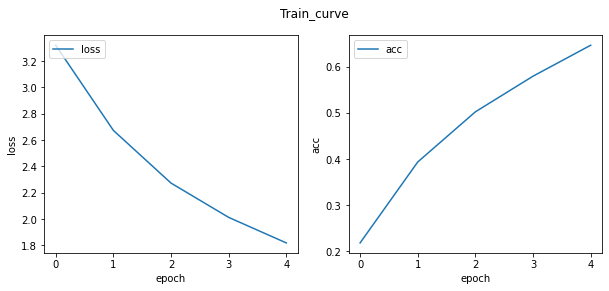

FileNotFoundError: ignored

<Figure size 432x288 with 0 Axes>

In [10]:
#pth = 'pth/my.pth'
#model.load_state_dict(torch.load(pth))
model = model.to(device)
criterion = LabelSmoothingCrossEntropy()
# criterion = FocalLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)#train without mixup
# optimizer = torch.optim.Adam(model.parameters(),lr=3e-2)

scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5)#b3(8 0.65) sgd(5,0.5)



train_loader,test_loader = Train_Testloader(data_jpg)
train_model(model,criterion,optimizer,scheduler,num_epochs,train_loader,test_loader)

In [11]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
import time, datetime
import pdb, traceback

# import imagehash
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from resnest.torch import resnest101
import torch
# torch.manual_seed(0)
# torch.backends.cudnn.deterministic = False
# torch.backends.cudnn.benchmark = True
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from torch.nn.parameter import Parameter

In [13]:
class MyDataset(Dataset):
    def __init__(self,test_jpg):
        self.test_jpg = test_jpg

        self.transforms = transforms.Compose([
            transforms.Resize(660),
            transforms.RandomCrop(600),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ])

    def __getitem__(self,index):

        img = Image.open(self.test_jpg[index]).convert('RGB')
        img = self.transforms(img)
            
        return img,torch.from_numpy(np.array(int('H' in self.test_jpg[index])))
    
    def __len__(self):
        return len(self.test_jpg)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.base = EfficientNet.from_pretrained('efficientnet-b3')
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._max_pooling = nn.AdaptiveMaxPool2d(1)
        num_ftrs = self.base._fc.in_features
        self.reduce_layer = nn.Conv2d(num_ftrs*2,512,1)#b3 num_ftrs=1536
        self._dropout = nn.Dropout(0.3)
        self._fc = nn.Linear(512,49)


    def forward(self,x):
        x = self.base.extract_features(x)
        x1 = self._avg_pooling(x)
        x2 = self._max_pooling(x)
        x = torch.cat([x1,x2],dim=1)
        x = self.reduce_layer(x)
        x = x.flatten(start_dim=1)
        x = self._dropout(x)
        x = self._fc(x)
        return x
# In[5]:


def predict(test_loader,model,tta=9):
    model.eval()
    
    test_pred_tta = None
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            for i,(inputs, target) in enumerate(test_loader):
                inputs = inputs.cuda()
                target = target.cuda()
                
                output = model(inputs)
                output = output.data.cpu().numpy()
                
                test_pred.append(output)
        test_pred = np.vstack(test_pred)
        
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
        # print(test_pred_tta)
    
    return test_pred_tta


In [15]:
test_jpg = ['test/{0}.jpg'.format(x) for x in range(800)]
test_jpg = np.array(test_jpg)


test_data = MyDataset(test_jpg)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# model = Net().cuda()
model = EfficientNet.from_pretrained('efficientnet-b3')
num_trs = model._fc.in_features
model._fc = nn.Linear(num_trs,49)
model = model.cuda()

test_pred = 0.


pth = 'drive/MyDrive/pth/model.pth'
model.load_state_dict(torch.load(pth))
test_pred = predict(test_loader, model, tta=9)

Loaded pretrained weights for efficientnet-b3


In [16]:
test_csv = pd.DataFrame()
test_csv['num'] = list(range(800))
test_csv['label'] = np.argmax(test_pred, 1)


test_csv.to_csv('drive/MyDrive/pth/result.csv', index=None,header=False)
print('successfule load!')

successfule load!
